# Plot effects of dicodon length and periodicity on mRNA levels

## Load libraries and define analysis-specific parameters

- We need to install both rsample and rasilabRtemplates in the Docker / Singularity container (or R conda environement?)

In [1]:
library(Biostrings)
library(tidyverse)
library(rasilabRtemplates)

insert_reads_cutoff <- 200 # The insert should get at least 200 reads across gRNA or mRNA
n_barcodes_cutoff <- 6 # The insert should have at least 6 barcodes across gRNA and mRNA after above cutoff

# Color-blind friendly palette. See http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: XVector

Loading required package: GenomeInfoDb


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:



## Read back barcode counts 

This is calculated in [plot_alignment_statistics.ipynb](plot_alignment_statistics.md).

In [2]:
barcode_counts <- read_tsv("../tables/sample_insert_barcode_counts.tsv.gz") %>% 
  rename(sample_type = sample_name, sample_name = cellline) %>% 
  filter(!is.na(sample_name))

barcode_counts  

Rows: 27840 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): sample_name, cellline
dbl (5): pool, insert_num, barcode_num, barcode_count, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sample_type,sample_name,pool,insert_num,barcode_num,barcode_count,linkage_count
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
stall4control4_grna,K562,6,5,12338,2551,1
stall4control4_grna,HeLa,5,4,7889,1779,303
stall4control4_grna,HeLa,5,5,7888,1628,431
stall4control4_grna,HeLa,5,2,7909,1107,223
stall4control4_grna,K562,6,3,10487,1041,333
stall4control4_grna,HeLa,5,3,7899,1000,254
stall4control4_grna,HCT116,4,7,7845,970,1
stall4control4_grna,HeLa,5,5,8016,941,151
stall4control4_grna,K562,6,5,11819,938,2


### Read insert annotations 

In [3]:

insert_annotations <- read_tsv("../../pool4_linkage/annotations/insert_annotations/stall4control4_linkage.tsv") %>% 
  print()

Rows: 8 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): insert_name, insert_seq, insert_type
dbl (4): group, insert_num, pair, frame

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 8 × 7
  group insert_name insert_seq                insert_type insert_num  pair frame
  <dbl> <chr>       <chr>                     <chr>            <dbl> <dbl> <dbl>
1     1 SVKF4       AGCGTCAAATTCTCCGTTAAGTTT… stall                0     4    NA
2     1 SKVF4       AGCAAAGTCTTCTCCAAGGTTTTT… control              1     4    NA
3     1 VK8         GTCAAAGTCAAAGTCAAAGTCAAA… stall                2     2     0
4     1 QS8         CAAAGTCAAAGTCAAAGTCAAAGT… control              3     2     2
5     1 SF8         AGTTTCAGTTTCAGTTTCAGTTTC… stall                4     3     0
6     1 FQ8         TTTCAGTTTCAGTTTCAGTTTCAG… control              5     3     2
7     1 RH8         CGCCATCGCCATCGCCATCGCCAT… stall                6     1     0
8     1 PS8         CCATCGCCATCGCCATCGCCATCG… control              7     1     2


### Function for bootstrap mRNA levels


In [4]:

calc_lfc_bootstrap <- function(data, indices) {
  d <- data[indices,]
  log2(sum(d$mrna)) - log2(sum(d$grna))
}

### Calculate mRNA levels of dicodons

- Log fold change is log2(mRNA/gRNA) and is median-normalized across the full library.

- Remove timecourse samples: we will analyze these seperately

In [5]:
# install.packages('boot')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [6]:
lfc <- barcode_counts %>% 
  # select only gRNA and mRNA samples, no timecourse samples 
  filter(str_detect(sample_type, "rna")) %>%
  # rename sample_type to just "grna" or "mrna" 
  mutate(sample_type = str_remove(sample_type, "stall4control4_")) %>% 
  pivot_wider(names_from = sample_type, values_from = barcode_count) %>%
  drop_na() %>% 
  group_by(insert_num, sample_name) %>% 
  nest() %>%
  mutate(lfc = map(data, function(df) boot::boot(data=df, statistic=calc_lfc_bootstrap, R=1000)$t)) %>%
  select(-data) %>%
  mutate(lfc_mean = map_dbl(lfc, mean)) %>%
  mutate(lfc_sd = map_dbl(lfc, sd)) %>%
  select(-lfc) %>%
  inner_join(insert_annotations, by = "insert_num") %>%
  print()

# A tibble: 28 × 10
# Groups:   sample_name, insert_num [28]
   sample_name insert_num lfc_mean lfc_sd group insert_name insert_seq          
   <chr>            <dbl>    <dbl>  <dbl> <dbl> <chr>       <chr>               
 1 K562                 5  -2.24   0.113      1 FQ8         TTTCAGTTTCAGTTTCAGT…
 2 HeLa                 4  -0.995  0.0987     1 SF8         AGTTTCAGTTTCAGTTTCA…
 3 HeLa                 5  -0.163  0.0585     1 FQ8         TTTCAGTTTCAGTTTCAGT…
 4 HeLa                 2  -2.47   0.136      1 VK8         GTCAAAGTCAAAGTCAAAG…
 5 K562                 3  -1.54   0.115      1 QS8         CAAAGTCAAAGTCAAAGTC…
 6 HeLa                 3  -0.888  0.0729     1 QS8         CAAAGTCAAAGTCAAAGTC…
 7 HCT116               7  -0.511  0.141      1 PS8         CCATCGCCATCGCCATCGC…
 8 HCT116               5  -0.652  0.0834     1 FQ8         TTTCAGTTTCAGTTTCAGT…
 9 HeLa                 7  -0.0157 0.0702     1 PS8         CCATCGCCATCGCCATCGC…
10 K562                 7  -1.31   0.0934     1 


### Plot VK8, RH8, SF8 effects by cellline

- So! These effects look the same as our initial analysis! 

- This is a good sign, because it means my linakge trimming seems to have worked correctly (at least for these samples). I was worried that the trimming resulted in my scrambling the inserts with their +2 frameshifted controls, but it seems that I trimmed correctly! 

- However, I think the timecourse samples are still messed up (may need different trimming parameters), and it seems like I somehow lost the SVKF controls as well (at which step, I'm not sure). 

# A tibble: 24 × 11
   sample_name insert_num lfc_mean lfc_sd group insert_name insert_seq          
   <chr>            <dbl>    <dbl>  <dbl> <dbl> <chr>       <chr>               
 1 K562                 5   -0.932 0.113      1 FQ8         TTTCAGTTTCAGTTTCAGT…
 2 HeLa                 4   -0.979 0.0987     1 SF8         AGTTTCAGTTTCAGTTTCA…
 3 HeLa                 5   -0.147 0.0585     1 FQ8         TTTCAGTTTCAGTTTCAGT…
 4 HeLa                 2   -2.45  0.136      1 VK8         GTCAAAGTCAAAGTCAAAG…
 5 K562                 3   -0.234 0.115      1 QS8         CAAAGTCAAAGTCAAAGTC…
 6 HeLa                 3   -0.873 0.0729     1 QS8         CAAAGTCAAAGTCAAAGTC…
 7 HCT116               7    0     0.141      1 PS8         CCATCGCCATCGCCATCGC…
 8 HCT116               5   -0.141 0.0834     1 FQ8         TTTCAGTTTCAGTTTCAGT…
 9 HeLa                 7    0     0.0702     1 PS8         CCATCGCCATCGCCATCGC…
10 K562                 7    0     0.0934     1 PS8         CCATCGCCATCGCCATCGC…
# … with

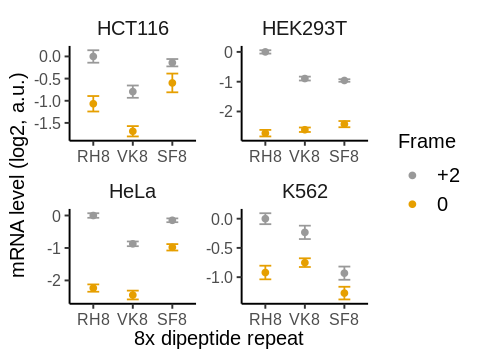

In [7]:
options(repr.plot.width=4, repr.plot.height=3)

plot_data <- lfc %>% 
  filter(!is.na(frame)) %>% 
  mutate(frame = as.factor(frame)) %>% 
  mutate(frame = fct_rev(fct_recode(frame, "0" = "0", "+2" = "2"))) %>% 
  mutate(label = pair) %>% 
  group_by(sample_name, pair) %>% 
  mutate(label = insert_name[insert_type == "stall"]) %>% 
  ungroup() %>% 
  mutate(label = fct_reorder(label, pair)) %>% 
  group_by(sample_name) %>% 
  mutate(lfc_mean = lfc_mean - max(lfc_mean)) %>% 
  ungroup() %>% 
  print()
  
plot_data %>% 
  ggplot(aes(x = label, y = lfc_mean, 
             ymin = lfc_mean - lfc_sd, ymax = lfc_mean + lfc_sd, color = frame)) +
  facet_wrap(~ sample_name, scales = "free") + 
  scale_color_manual(values = cbPalette) +
  geom_errorbar(width = 0.3, show.legend = F) + 
  geom_point() +
  labs(x = "8x dipeptide repeat", y = "mRNA level (log2, a.u.)", color = "Frame")

# ggsave("../figures/multiple_celllline_dipeptide_mrna_effect.pdf")

# Plot SVKF4 effect by cell line

- Huh.. weird. Where did the control inserts for the SVKF test go? 

- Maybe these were somehow filtered out at an earlier step?

```{r, fig.width=2, fig.height=1.5}

In [11]:
## Where did we lose SKVF control?

insert_annotations
# SKVF insert number = 1. Is this present in the barcode counts? 
# SVKF beta insert is present
barcode_counts %>% filter(insert_num == 0) %>% print 
# SKVF alpha control insert is not present.. 
barcode_counts %>% filter(insert_num == 1) %>% print 
# Okay, so this was lost at an earlier processing step. Either in the barcode count generation script, or at the linkage stage. 

group,insert_name,insert_seq,insert_type,insert_num,pair,frame
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,SVKF4,AGCGTCAAATTCTCCGTTAAGTTTAGTGTAAAGTTTTCGGTGAAATTC,stall,0,4,NA
1,SKVF4,AGCAAAGTCTTCTCCAAGGTTTTTAGTAAGGTATTTTCGAAAGTGTTC,control,1,4,NA
1,VK8,GTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAA,stall,2,2,0
1,QS8,CAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGTCAAAGT,control,3,2,2
1,SF8,AGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTC,stall,4,3,0
1,FQ8,TTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAGTTTCAG,control,5,3,2
1,RH8,CGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCAT,stall,6,1,0
1,PS8,CCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCGCCATCG,control,7,1,2


# A tibble: 562 × 7
   sample_type         sample_name  pool insert_num barcode_num barcode_count
   <chr>               <chr>       <dbl>      <dbl>       <dbl>         <dbl>
 1 stall4control4_grna HeLa            5          0        7907           525
 2 stall4control4_grna K562            6          0       10475           497
 3 stall4control4_grna HeLa            5          0        8207           419
 4 stall4control4_grna K562            6          0       10552           400
 5 stall4control4_grna HeLa            5          0        8057           395
 6 stall4control4_grna K562            6          0       11676           372
 7 stall4control4_grna HeLa            5          0        7992           368
 8 stall4control4_grna HeLa            5          0        8866           338
 9 stall4control4_grna HeLa            5          0        8014           335
10 stall4control4_grna HeLa            5          0        8242           326
# … with 552 more rows, and 1 more variable:

In [10]:
# Can't do this analysis until we figure out what happened to te SKVF control sequences
# Misannotated somewhere at the linkage stage? Must've been.. 

plot_data <- lfc %>% print %>%
  filter(is.na(frame)) %>% 
  group_by(sample_name) %>% 
  mutate(lfc_mean = lfc_mean - lfc_mean[insert_type == "control"]) %>% 
  ungroup() %>% 
  print()
  
plot_data %>% 
  ggplot(aes(x = sample_name, y = lfc_mean, 
             ymin = lfc_mean - lfc_sd, ymax = lfc_mean + lfc_sd, color = insert_name)) +
  scale_color_manual(values = cbPalette) +
  geom_errorbar(width = 0.3, show.legend = F) + 
  geom_point() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Cell line", y = "mRNA level (log2, a.u.)", color = "")

# ggsave("../figures/multiple_celllline_svkf_mrna_effect.pdf")

# A tibble: 28 × 10
# Groups:   sample_name, insert_num [28]
   sample_name insert_num lfc_mean lfc_sd group insert_name insert_seq          
   <chr>            <dbl>    <dbl>  <dbl> <dbl> <chr>       <chr>               
 1 K562                 5  -2.24   0.113      1 FQ8         TTTCAGTTTCAGTTTCAGT…
 2 HeLa                 4  -0.995  0.0987     1 SF8         AGTTTCAGTTTCAGTTTCA…
 3 HeLa                 5  -0.163  0.0585     1 FQ8         TTTCAGTTTCAGTTTCAGT…
 4 HeLa                 2  -2.47   0.136      1 VK8         GTCAAAGTCAAAGTCAAAG…
 5 K562                 3  -1.54   0.115      1 QS8         CAAAGTCAAAGTCAAAGTC…
 6 HeLa                 3  -0.888  0.0729     1 QS8         CAAAGTCAAAGTCAAAGTC…
 7 HCT116               7  -0.511  0.141      1 PS8         CCATCGCCATCGCCATCGC…
 8 HCT116               5  -0.652  0.0834     1 FQ8         TTTCAGTTTCAGTTTCAGT…
 9 HeLa                 7  -0.0157 0.0702     1 PS8         CCATCGCCATCGCCATCGC…
10 K562                 7  -1.31   0.0934     1 

ERROR: [1m[33mError[39m in [1m[1m`mutate_cols()`:[22m
[33m![39m Problem with `mutate()` column `lfc_mean`.
[34mℹ[39m `lfc_mean = lfc_mean - lfc_mean[insert_type == "control"]`.
[34mℹ[39m `lfc_mean` must be size 1, not 0.
[34mℹ[39m The error occurred in group 1: sample_name = "HCT116".
